In [1]:
import numpy as np
import scipy
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
from tqdm import tqdm
from oracles import QuadraticOracle, create_log_reg_oracle
from optimization import conjugate_gradients, hessian_free_newton, lbfgs, gradient_descent

# 1. Зависимость числа итераций метода сопряженных градиентов от числа обусловленности и размерности пространства

In [2]:
def create_equation(k=1, n=2):
    if k == 1:
        diag = np.ones(n)
    else:
        diag = np.random.randint(1, k, size=n)
    diag[0] = 1
    diag[1] = k
    A = scipy.sparse.diags(diag)
    b = np.random.uniform(0, 1, size=n)
    matvec = lambda x: A.dot(x)
    return matvec, b

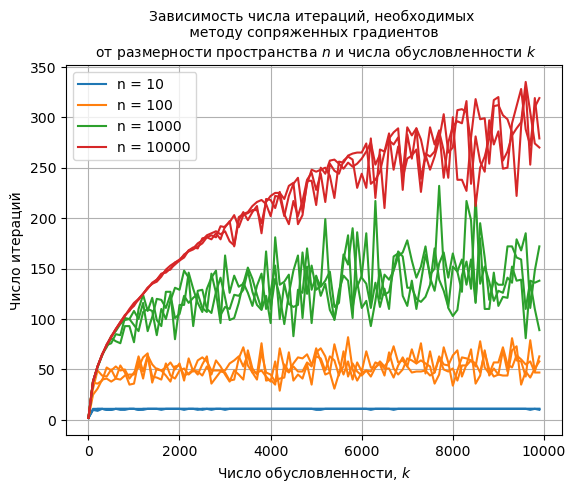

In [3]:
np.random.seed(42)
ns = np.logspace(1, 4, dtype=int, num=4)
n_exp = 3
ks = np.arange(1, 10000, 100)
T = np.zeros(len(ks))
for i in range(len(ns)):
    for j in range(n_exp):
        for k in range(len(ks)):
            x0 = np.zeros(ns[i])
            matvec, b = create_equation(ks[k], ns[i])
            T[k] = len(conjugate_gradients(matvec, b, x0, trace=True)[2]['time'])
        plt.plot(ks, T, label=f'n = {ns[i]}' if j == 0 else None, color=f'C{str(i)}')
plt.xlabel('Число обусловленности, $k$')
plt.ylabel('Число итераций')
plt.title('Зависимость числа итераций, необходимых \n методу сопряженных градиентов \n от размерности пространства $n$ и числа обусловленности $k$', fontsize=10)
plt.legend()
plt.grid()
plt.show()

# 2. Выбор размера истории в методе L-BFGS

In [4]:
from sklearn.datasets import load_svmlight_file

In [5]:
X, y = load_svmlight_file('gisette_scale.bz2')

In [6]:
oracle = create_log_reg_oracle(X, y, regcoef=1/X.shape[0])
x_0 = np.zeros(X.shape[1])

In [7]:
ls = [0, 1, 5, 10, 50, 100]
LBFGS_results = []
for l in ls:
    LBFGS_results.append(lbfgs(oracle, x_0, trace=True, tolerance=1e-10, memory_size=l))

In [8]:
def plot_lbfgs_results(results=None, ls=None, xaxis='iter'):
    for res, l in zip(results, ls):
        ys = np.array(res[2]['grad_norm'])
        xs = np.arange(len(ys)) if xaxis == 'iter' else res[2]['time']
        plt.semilogy(xs, ys**2 /ys[0] ** 2, label = f'размер истории = {l}')
    plt.ylabel('Относительная ошибка')
    plt.title('Относительная ошибка по квадрату нормы градиента \n для разных размеров истории')
    plt.xlabel('Число итераций' if xaxis=='iter' else 'Время, c')
    plt.legend()
    plt.grid()

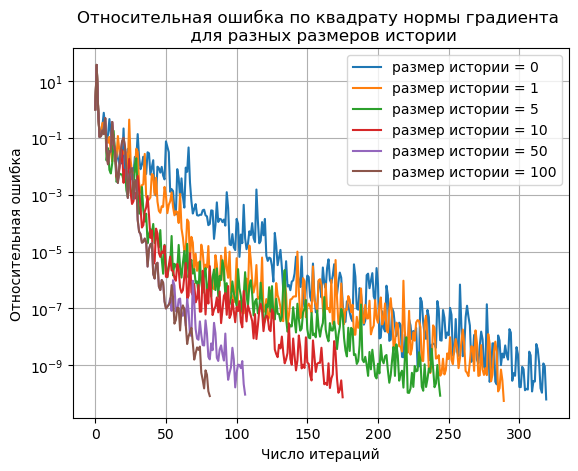

In [9]:
plot_lbfgs_results(results=LBFGS_results, ls=ls, xaxis='iter')
plt.show()

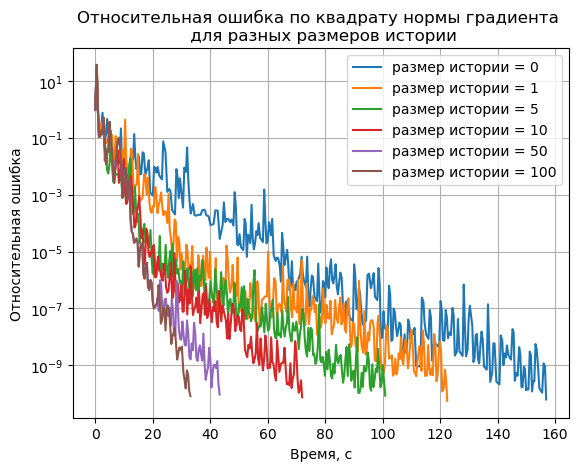

In [10]:
plot_lbfgs_results(results=LBFGS_results, ls=ls, xaxis='time')
plt.show()

In [11]:
X, y = load_svmlight_file('news20.binary.bz2')

In [12]:
oracle = create_log_reg_oracle(X, y, regcoef=1/X.shape[0])
x_0 = np.zeros(X.shape[1])

In [13]:
ls = [0, 1, 5, 10, 50, 100]
LBFGS_results = []
for l in ls:
    LBFGS_results.append(lbfgs(oracle, x_0, trace=True, tolerance=1e-10, memory_size=l))

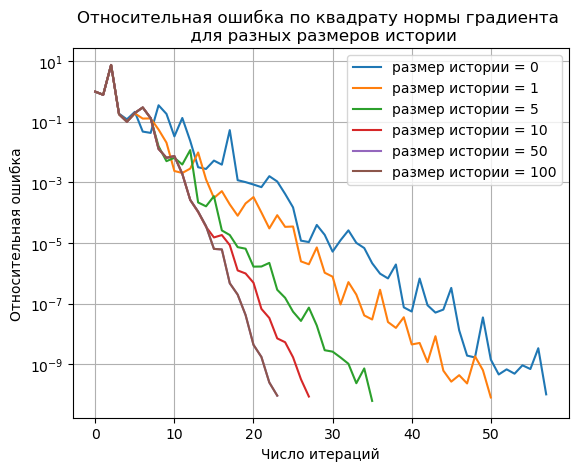

In [14]:
plot_lbfgs_results(results=LBFGS_results, ls=ls, xaxis='iter')
plt.show()

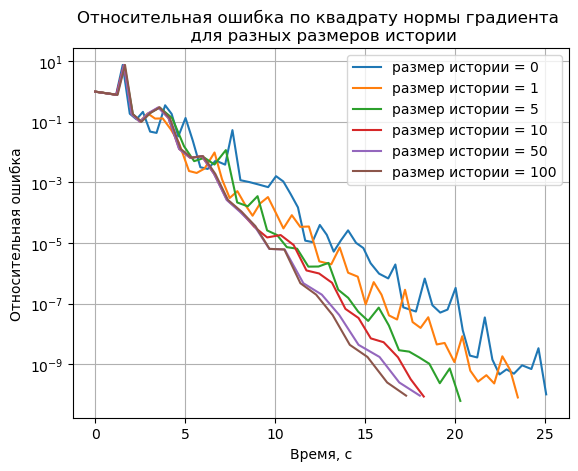

In [15]:
plot_lbfgs_results(results=LBFGS_results, ls=ls, xaxis='time')
plt.show()

# 3. Сравнение методов на реальной задаче логистической регрессии

In [16]:
tasks = ['w8a.txt', 'gisette_scale.bz2', 'real-sim.bz2', 'news20.binary.bz2', 'rcv1_test.binary.bz2']

In [43]:
hf_newton_results = []
gd_results = []
LBFGS_results = []
for task in tasks:
    X, y = load_svmlight_file(task)
    oracle = create_log_reg_oracle(X, y, regcoef=1/X.shape[0])
    x_0 = np.zeros(X.shape[1])
    gd_results.append(gradient_descent(oracle, x_0, trace=True, max_iter=300))
    hf_newton_results.append(hessian_free_newton(oracle, x_0, trace=True))
    LBFGS_results.append(lbfgs(oracle, x_0, trace=True))

In [18]:
def plot_results(task=None, mode=None):
    idx = tasks.index(task)
    res = [gd_results, hf_newton_results, LBFGS_results]
    labels = ['градиентный спуск', 'усеченный метод Ньютона', 'L-BFGS']
    fig, ax = plt.subplots(figsize=(7.5,5))
    for i in range(3):
        if mode == 'a':
            ys = res[i][idx][2]['func']
            xs = np.arange(len(ys))
        elif mode == 'b':
            ys = res[i][idx][2]['func']
            xs = res[i][idx][2]['time']
        else:
            ys = np.array(res[i][idx][2]['grad_norm'])
            ys = ys ** 2 / ys[0] ** 2
            xs = res[i][idx][2]['time']
        ax.semilogy(xs, ys, label = labels[i])
    title = 'Значение функции' if mode == 'a' or mode == 'b' else 'Относительная норма градиента' 
    ax.set_xlabel('Число итераций' if mode == 'a' else 'Время, с')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid()

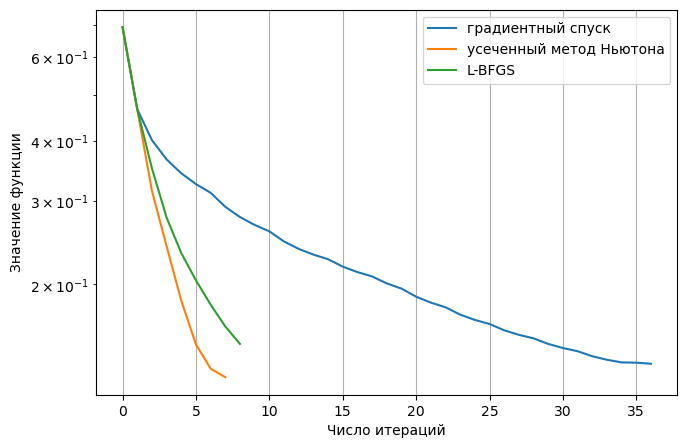

In [19]:
plot_results('w8a.txt', mode='a')
plt.show()

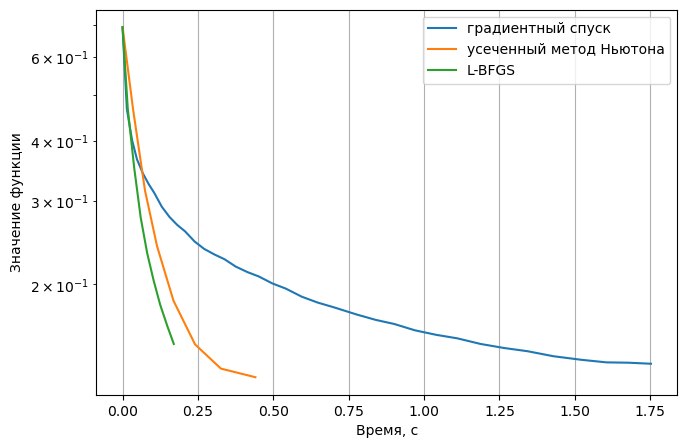

In [20]:
plot_results('w8a.txt', mode='b')
plt.show()

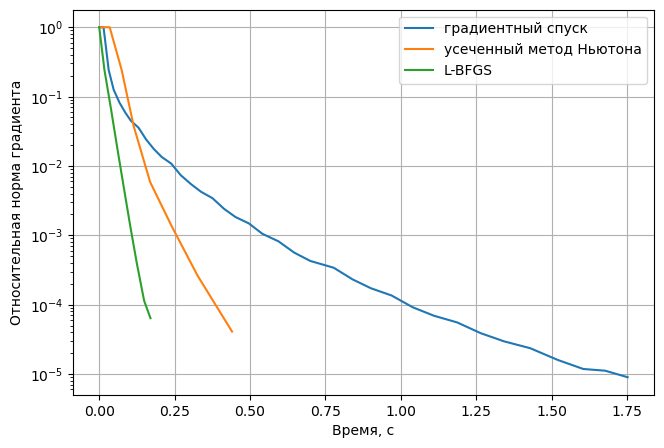

In [21]:
plot_results('w8a.txt', mode='c')
plt.show()

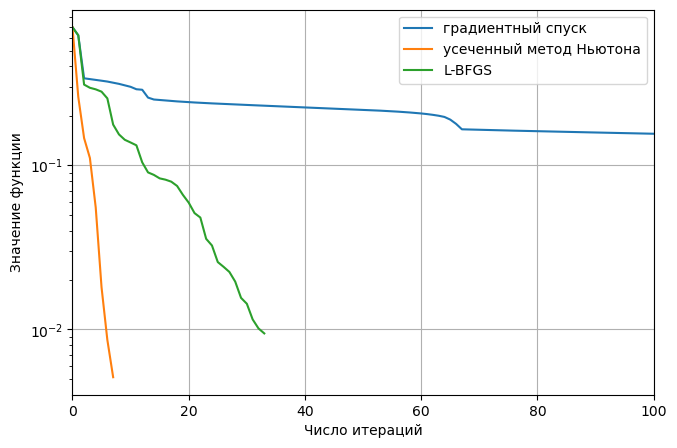

In [22]:
plot_results('gisette_scale.bz2', mode='a')
plt.xlim(0,100)
plt.show()

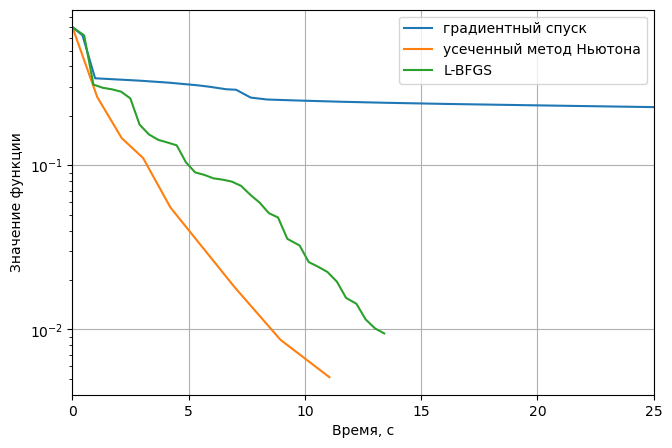

In [23]:
plot_results('gisette_scale.bz2', mode='b')
plt.xlim(0,25)
plt.show()

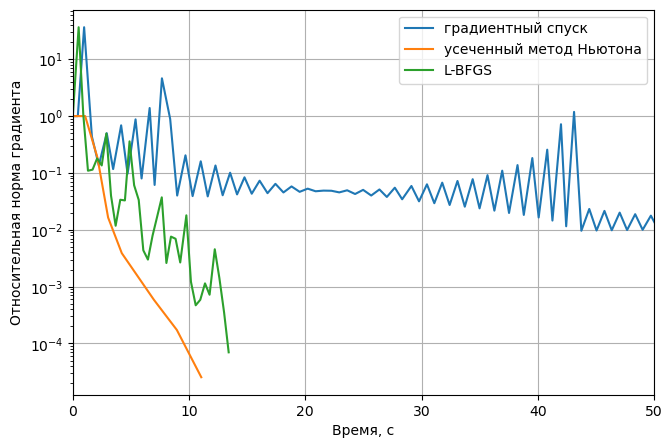

In [24]:
plot_results('gisette_scale.bz2', mode='c')
plt.xlim(0,50)
plt.show()

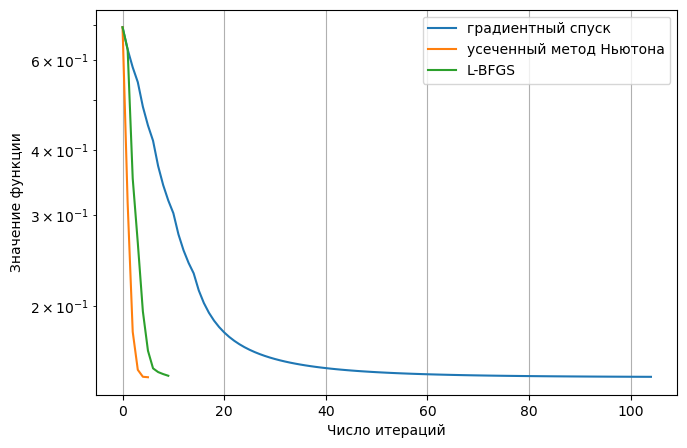

In [25]:
plot_results('real-sim.bz2', mode='a')
plt.show()

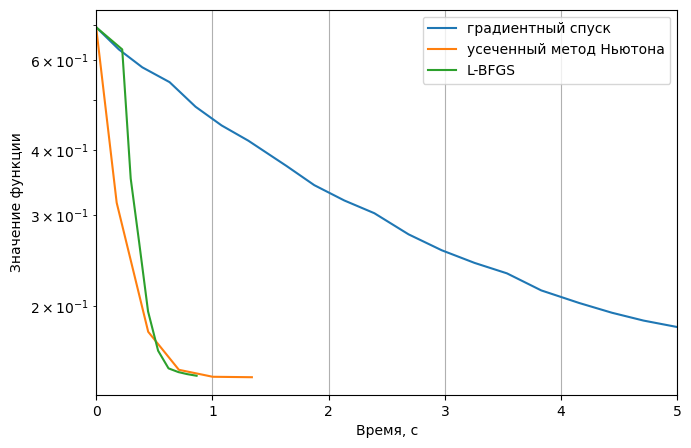

In [26]:
plot_results('real-sim.bz2', mode='b')
plt.xlim(0,5)
plt.show()

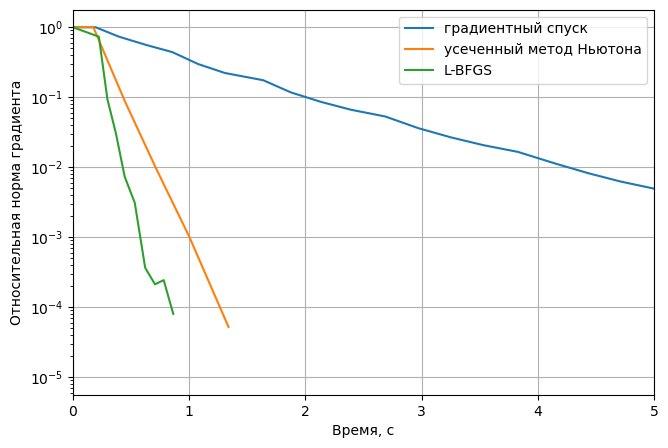

In [27]:
plot_results('real-sim.bz2', mode='c')
plt.xlim(0,5)
plt.show()

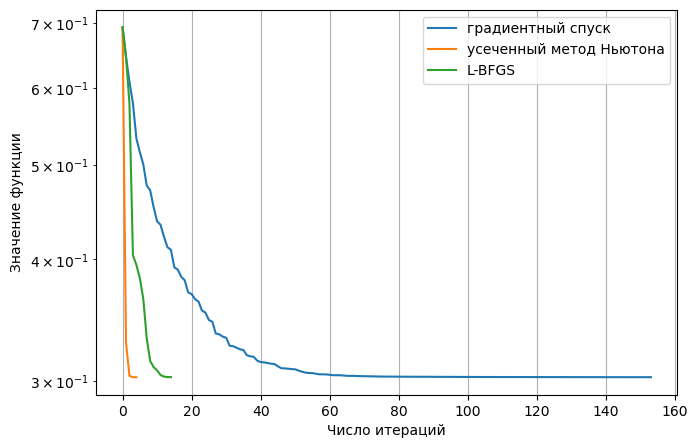

In [28]:
plot_results('news20.binary.bz2', mode='a')
plt.show()

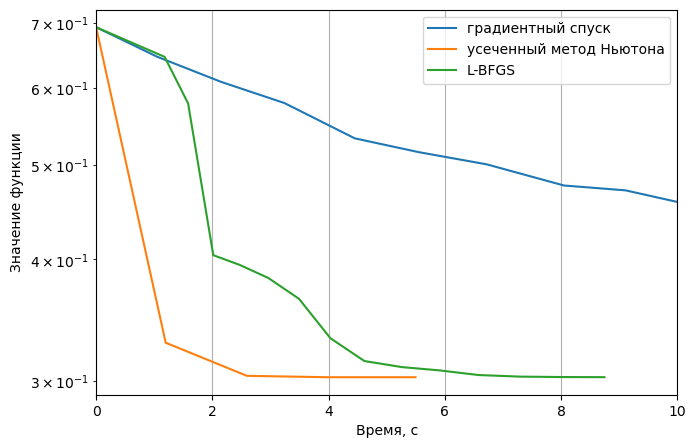

In [29]:
plot_results('news20.binary.bz2', mode='b')
plt.xlim(0,10)
plt.show()

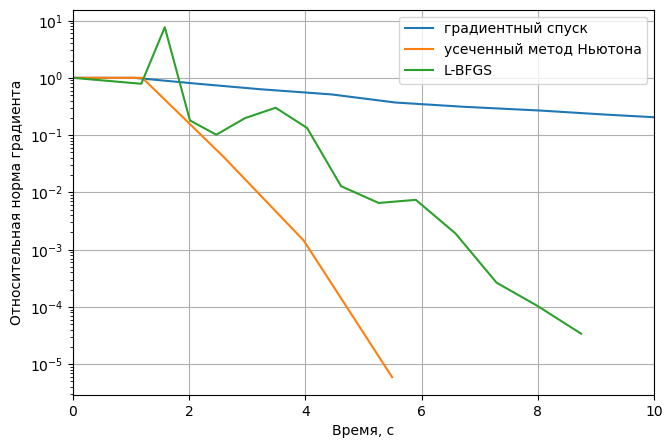

In [30]:
plot_results('news20.binary.bz2', mode='c')
plt.xlim(0,10)
plt.show()

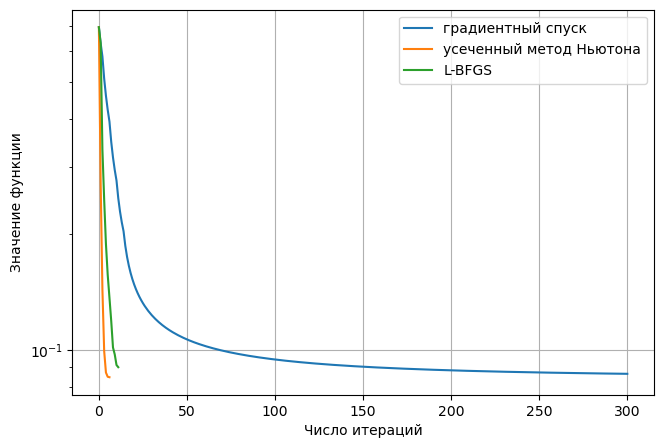

In [31]:
plot_results('rcv1_test.binary.bz2', mode='a')
plt.show()

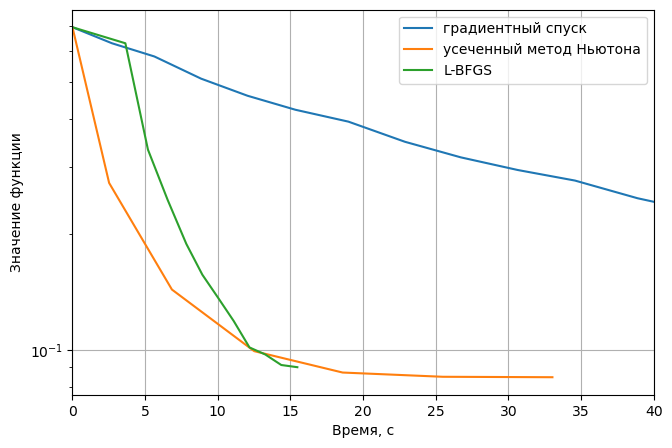

In [32]:
plot_results('rcv1_test.binary.bz2', mode='b')
plt.xlim(0,40)
plt.show()

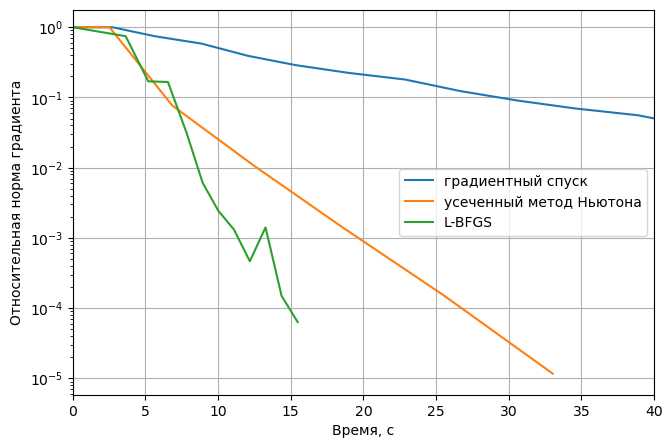

In [33]:
plot_results('rcv1_test.binary.bz2', mode='c')
plt.xlim(0,40)
plt.show()

# 4. Сравнения метода сопряженных градиентов и L-BFGS на квадратичной функции

In [34]:
np.random.seed(42)
n1 = 100
n2 = 10
A1 = np.diag(np.random.randint(1, 1000,size=n1))
A2 = np.diag(np.random.randint(1, 1000,size=n2))
b1 = np.random.uniform(1, 1000, size=n1)
b2 = np.random.uniform(1, 1000, size=n2)

In [35]:
def plot_error(A, b, memory_size=10):
    n = b.shape
    oracle = QuadraticOracle(A, b)
    x_0 = np.zeros(n)
    #LBFGS_res = lbfgs(oracle, x_0, trace=True, tolerance=1e-10,
     #                memory_size=memory_size)[2]['grad_norm']
    LBFGS_res = lbfgs(oracle, x_0, line_search_options={'method' : 'Best'}, trace=True, tolerance=1e-10,
                     memory_size=memory_size)[2]['grad_norm']
    matvec = lambda x: A.dot(x)
    conj_grad_res = conjugate_gradients(matvec, b, x_0, tolerance = 1e-10, trace=True)[2]['residual_norm']
    plt.semilogy(np.arange(len(LBFGS_res)), LBFGS_res, '--',linewidth=3, label = f'L-BFGS, история: {memory_size}')
    plt.semilogy(np.arange(len(conj_grad_res)), conj_grad_res, label = 'сопряженные градиенты')
    plt.xlabel('Номер итерации')
    plt.ylabel('Норма невязки')
    plt.title(f'$n = {n[0]}$')
    plt.legend()
    plt.grid()

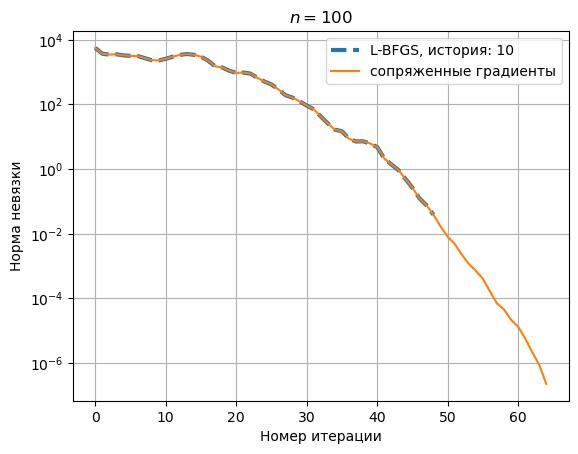

In [36]:
plot_error(A1, b1)
plt.show()

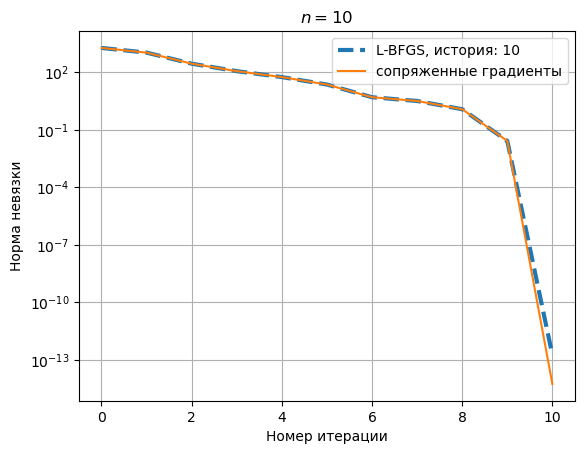

In [37]:
plot_error(A2,b2)
plt.show()

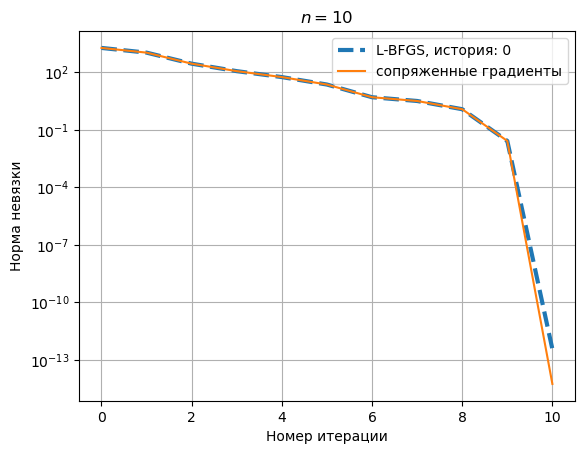

In [38]:
plot_error(A2,b2, 0)
plt.show()

# 5. Какая точность отимизации нужна в реальных задачах

In [39]:
def plot_misclas(data='w8a.txt'):
    eps = np.logspace(0, -8, 9)
    err = []
    X, y = load_svmlight_file(data)
    oracle = create_log_reg_oracle(X, y, regcoef=1/X.shape[0])
    x_0 = np.zeros(X.shape[1])
    for e in eps:
        x_opt =  lbfgs(oracle, x_0, tolerance=e)[0]
        err.append((1-np.mean(np.sign(oracle.matvec_Ax(x_opt)) == y)) * 100)
    plt.xlabel('Точность оптимизации ')
    plt.ylabel('Процент неправильно классифицированных точек')
    plt.title(f'{data[:-4]}')
    plt.semilogx(eps,err)
    plt.grid()

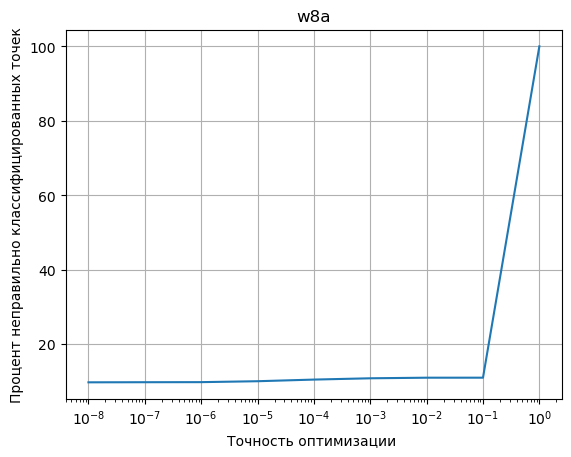

In [40]:
plot_misclas()
plt.show()

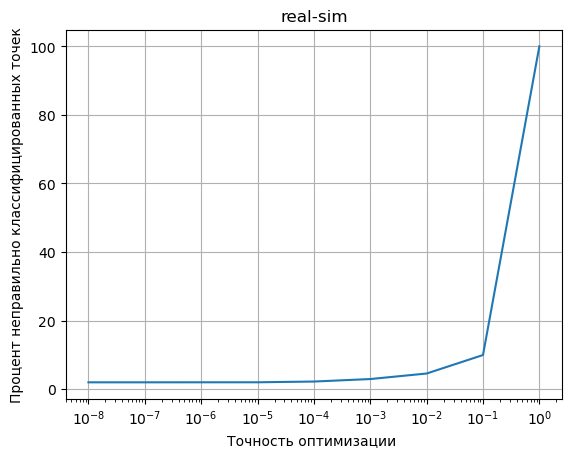

In [41]:
plot_misclas('real-sim.bz2')
plt.show()

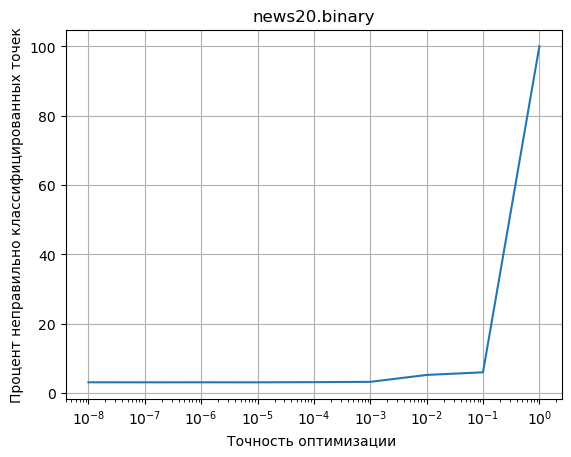

In [42]:
plot_misclas('news20.binary.bz2')
plt.show()